# 프로젝트: 자율주행 보조 시스템 만들기

In [1]:
import tensorflow as tf

print(tf.__version__)

2.6.0


## 시스템 목표

아래 환경의 함수 만들기
* 입력으로 이미지 경로
* 정지 조건에 맞는 경우 "Stop" 아닌 경우 "Go" 반환

실행 조건
* 사람이 한 명 이상이 있는 경우 [Instance Segmentation 기법으로 접근]
* 차량의 크기가 300px이상인 경우 [차량의 Bbox 크기로 접근]

추가 요소
* 사람이 인도에 있는가 도로에 있는가

## 실행 코드 예시

```
def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))
```

## 시스템 평가 코드 예시

```
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)
```

## 평가 요소

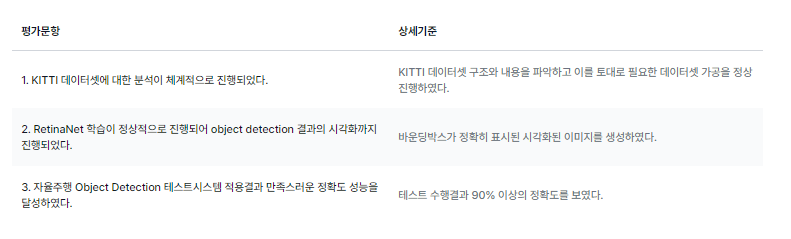

# 데이터셋 분석 및 처리

활용 데이터셋 - KITTI 데이터셋 [cvlibs]

In [2]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

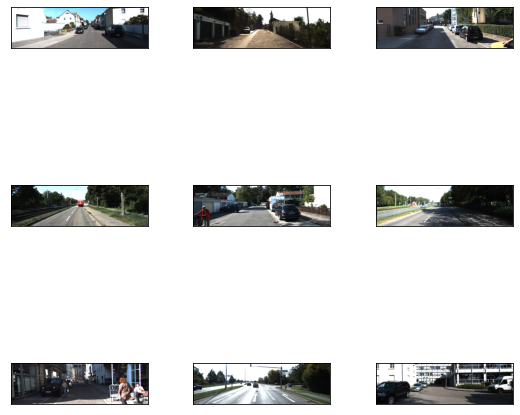

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### 단순 Info 활용 데이터 분석

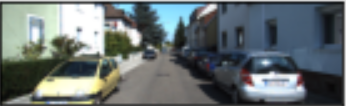

이미지를 자세히 살펴보면 차량이 주차된 경우도 보임

-> 결국 이 차량이 움직이는 지 멈추는지를 판단하는건 인간적인 추론이 되지 않는다면 1장의 사진으로는 절대 detection으로 추론 불가능하기에 이후 테스트 이미지를 선별할때 이런 주차된 사진들을 빼고 테스트 하는것이 좋을 것으로 보임

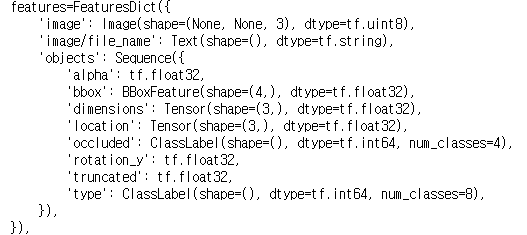

들어가 있는 이미지의 형식은 사이즈는 사진별로 다른것으로 보이고, 3차원의 이미지. BBox는 4차원의 데이터로 들어가 있는 것을 볼 수 있그 그 외에 위치, occluded(막힌), 회전, 축소 등의 여부들도 같이 포함되어 있는 것을 볼 수 있음.

모든 요소들을 어떻게 활용할 방법을 찾을 순 있지만 지금의 task 상으로는 detection 모델에 필요한 데이터셋만 선별하여 활용하는 것이 좋아 보임

### 데이터 세부 내용 파악

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(13,), dtype=float32, numpy=
array([-1.55, -1.99, -2.13, -2.16, -2.3 , -2.03, -1.83, -1.68, -1.64,
       -1.55,  2.19,  2.13,  2.06], dtype=float32)>, 'bbox': <tf.Tensor: shape=(13, 4), dtype=float32, numpy=
array([[0.4084    , 0.4633897 , 0.5313067 , 0.50904185],
       [0.20341334, 0.15066023, 0.51501334, 0.33787438],
       [0.29858667, 0.2084541 , 0.5322667 , 0.36200482],
       [0.39384   , 0.30635265, 0.52757335, 0.39949274],
       [0.43048   , 0.34957325, 0.54021335, 0.42619163],
       [0.00266667, 0.6316345 , 0.8576533 , 0.99919486],
       [0.26834667, 0.5968518 , 0.51608   , 0.7225604 ],
       [0.43250668, 0.5365137 , 0.52581334, 0.5761594 ],
       [0.47877333, 0.51508856, 0.57397336, 0.5426731 ],
       [0.45312   , 0.47412238, 0.54176   , 0.50346214],
       [0.22984   , 0.        , 0.67130667, 0.1531562 ],
       [0.40853333, 0.06677134, 0.52589333, 0.1541868 ],

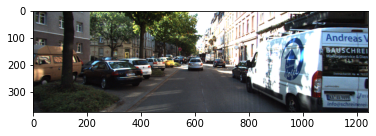

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

여기서 주의해야 할 점은 해당 데이터셋의 좌표계가 반대라는 점이다

y가 줄어들수록 밑에서 위로 가고, 늘어날수록 위에서 아래로 가는 형식이다

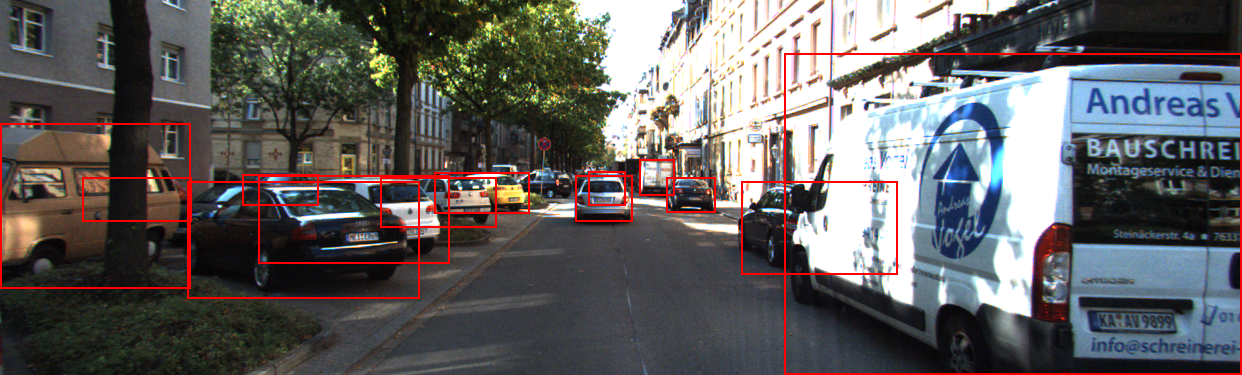

In [7]:
# 이미지에 BBox 표시 함수
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = input_image.size
    x_min = object_bbox[:,1] * width # 이미지의 왼쪽 좌표를 너비에 맞게 변환
    x_max = object_bbox[:,3] * width # 이미지의 오른쪽 좌표를 너비에 맞게 변환
    y_min = height - object_bbox[:,0] * height # 이미지의 상단 좌표를 좊이에 맞게 변환
    y_max = height - object_bbox[:,2] * height # 이미지의 하단 좌표를 높이에 맞게 변환
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

여기까지 학습에 들어갈 데이터셋을 정의하였고, 이 데이터들이 어떻게 구성되어 있는지 파악하였다.

* 데이터셋: ds_train, ds_test
* 함수: visualize_bbox

추가 작업

* x와 y좌표 위치 교체
* 무작위 수평 뒤집기
* 이미지 크기 조정 및 패딩 추가
* 좌표계가 [x_min, y_min, x_max, y_max]로 구성되어 있고 이를 [x_min, y_min, width, height]으로 수정 필요

### 데이터 전처리 작업

In [8]:
# x와 y 좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [9]:
# 약 반개정도 랜덤하게 추출하여 x를 기준으로 Flib
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [10]:
# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [11]:
# 좌표계 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [12]:
# 이전에 선언한 함수를 통한 전처리
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩 작업

이번프로젝트에서는 RetinaNet을 기본 모델로 사용하기에, FPN의 특성에 맞춰(각 층마다 필요한 Anchor가 정해져 많은 양의 Anchor가 필요) 작업 시행.
이 구조는 최대한 논문의 구조에 맞게 시행

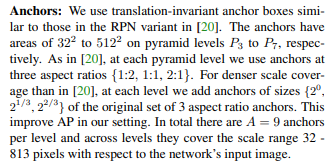

* RPN 변형 모델과 유사하게 변환 불변 앵커 박스 사용
* 앵커는 피라미드 레벨 P3에서 P7까지 각각 $32^2$에서 $512^2$의 면적을 갖음
* 각 피라미드 레벨에서 세가지 종횡비 $1:2, 1:1, 2:1$로 앵커를 사용
* 더 촘촘한 스케일 범위를 위해 각 레벨에서 원래의 세 가지 종횡비 앵커 세트의 크기 $2^0, 2^{1/3}, 2^{2/3}$에 해당하는 앵커를 추가
* 총 레벨당 A=9개의 앵커가 있으며, 각 레벨에 걸쳐 네트워크의 입력 이미지에 대해 32 - 813 픽셀의 스케일 범위를 커버함

In [13]:
class AnchorBox:
    def __init__(self):
        # 1:2, 1:1, 2:1 종횡비 앵커
        self.aspect_ratios = [0.5, 1.0, 2.0]
        # 종횡비 앵커 세트의 크기
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        # P3 부터 P7 까지의 면적
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


In [14]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [15]:
# 이전에 선언한 함수들을 활용하여 Label Encoder 제작
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# 모델 작성

모델은 RetinaNet을 사용하고 FPN을 약간 수정해서 사용하였기에 논문을 참고하여 비슷하게 구현

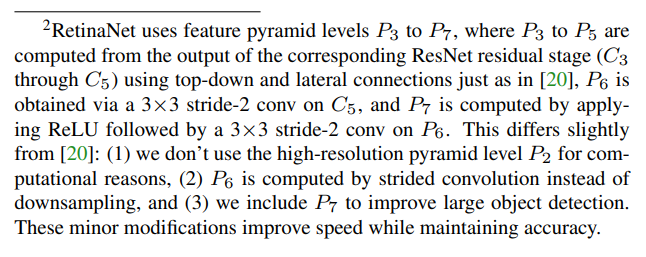

RetinaNet은 피라미드 레벨 P3에서 P7을 사용합니다. 여기서 P3에서 P5는 ResNet 잔여 스테이지 (C3부터 C5까지)의 출력을 사용하여 상향식 및 측면 연결로 계산됨.
P6는 C5에 3 * 3 스트라이트-2 컨볼루션을 적용하여 얻어지며, P7은 P6에 ReLU를 적용한 후 3 * 3 스트라이드-2 컨볼루션을 적용하여 계산됨.

[특징]
1. 계산상의 이유로 고해상도 피라미드 레벨 P2를 사용하지 않음
2. P6는 다운샘플링 대신 스트라이드 컨볼루션으로 계산됨
3. P7을 포함하여 큰 물체 감지를 개선함

In [16]:
import tensorflow as tf

class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        # P7은 P6에 ReLU를 적용한 후 3 * 3 스트라이드-2 컨볼루션을 적용하여 계산
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    # 커널 초기화를 정규분포로 구성
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    
    # 4개의 Conv2D 레이어와 ReLU 활성화 함수 추가
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    
    # 최동 Conv2D 레이어 추가, Output_filters 개수 만큼의 출력을 지님
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [18]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [20]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# 모델 학습 및 평가

[평가요소]
1. Object Detection을 제대로 수행 가능한가
2. RetinaNet 모델이 활용되었는가
3. 적절한 epoch, batch_size, Learning Rate 및 기타 하이퍼 파라미터 튜닝이 들어갔는가
4. 학습과정에서 평가를 위한 시각화가 적절한가

[주의사항]
* 모든 평가의 비교요소는 비교댓항 제외 동일한 환경에서 수행되어야 한다

[사용 모델]
**RetinaNet**


In [21]:
import numpy as np

num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [22]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [24]:
model_dir = os.getenv('HOME') + '/aiffel/git/ai/Quests/Quest14_20240712/checkpoints/'

"""
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 15

history= model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks_list
)
"""

'\ncallbacks_list = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),\n        monitor="loss",\n        save_best_only=False,\n        save_weights_only=True,\n        verbose=1,\n    )\n]\n\nepochs = 15\n\nhistory= model.fit(\n        train_dataset,\n        validation_data=val_dataset,\n        epochs=epochs,\n        callbacks=callbacks_list\n)\n'

In [25]:
"""
import pickle


his_dir = os.getenv('HOME') + '/aiffel/git/ai/Quests/Quest14_20240712/history/'
os.makedirs(his_dir, exist_ok=True)  # 디렉토리가 없는 경우 생성

# history 객체 저장 경로 설정
history_path = os.path.join(his_dir, 'history.pkl')

# history 객체 저장
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
"""

NameError: name 'history' is not defined

In [ ]:
"""
# history 객체 불러오기
with open('history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)
"""

In [ ]:
"""
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # 학습 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    """

In [ ]:
"""
# 학습 성능 시각화
plot_training_history(history)
"""

# 모델 평가

In [119]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
# latest_checkpoint = model_dir + 'weights_epoch_8'
model.load_weights(latest_checkpoint)

In [120]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [121]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [122]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [123]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

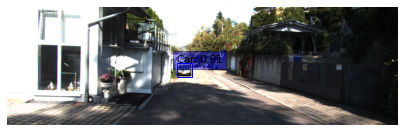

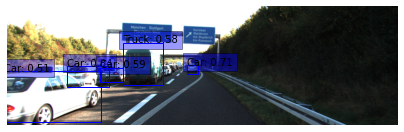

In [124]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 주율주행 시스템 구성 및 평가

이전 단계에서 예측한 데이터를 통해 자동차의 판단 기준을 세워 테스트를 진행해 보았다.

1. 우선 검출된 박스의 크기를 기준으로 threshold를 정해 크기가 너무 커지면 stop을 하도록 진행

```
if box_width > 200 or box_height > 150:
```

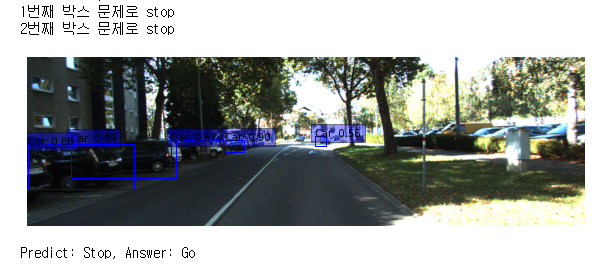

위 사진처럼, 그렇게 진행했을 경우 완전히 갓길에 있는 차량 1번,2번의 경우에도 Stop을 하게되는 문제 발생

2. 박스가 이미지의 1/3, 2/3 지점을 기준으로 그 사이에 왔을 때의 상황 무시[갓길이나 다른 차선으로 판단]

```
if boxes[i, 2].numpy() > thre_right:
                if boxes[i, 0].numpy() < thre_left:
```

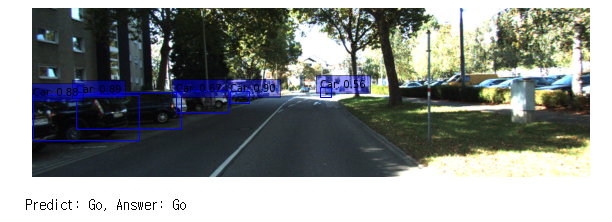

Trouble Souting:
처음에 코드를 or를 써서
```
if boxes[i, 2].numpy() > thre_right or boxes[i, 0].numpy() < thre_left:
```
이렇게 구성하였지만 해결되지 않았음, 하나씩 출력해보면서 or를 하게되면 차량이 좌측에 있는 경우 박스 왼쪽 좌표가 이미지의 2/3 보다 작은지점에 (원래 의도는 오른쪽에 위치한 차량 패스) 해당하게 되어 제대로 걸러지지 않았던 문제 발생

다시 위처럼 코드를 구성하여 이 문제를 해결

선택요소로 차량의 가로 세로 비율을 계산하여 갓길에 세워진 차량의 경우 이 비율이 클것임을 이용하여 코드를 만들려고 생각했지만 반대로 교차로의 경우의 문제도 있기 때문에 이 부분은 따로 사용하지 않는것이 좋아 보일것으로 예상

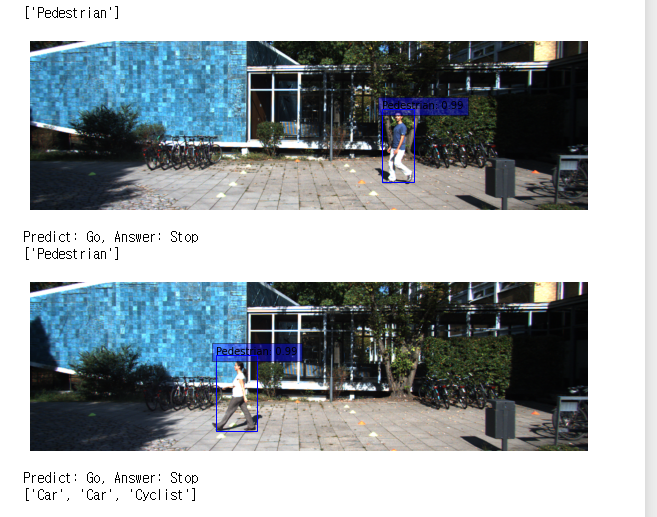

사람의 경우 조금은 다른 기준을 줘야하기에 각 class name을 반영한 후 또다른 bounding box 기준을 생성 및 적용

하지만 새로운 문제로 모델의 학습이 불안정하다보니 예측을 진행할때마다 아래처럼 정확도가 확 떨어지는 현상 발생

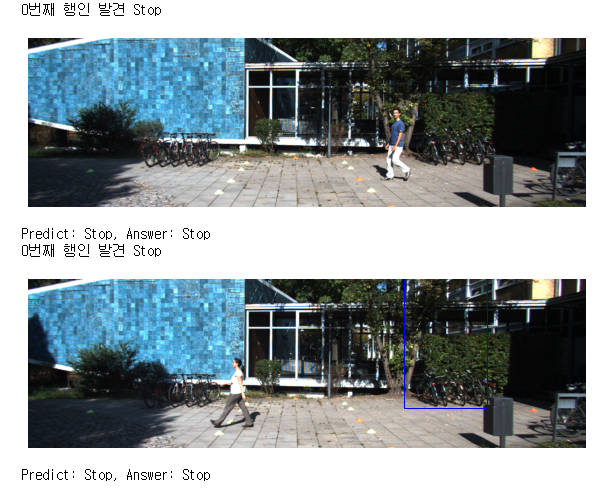

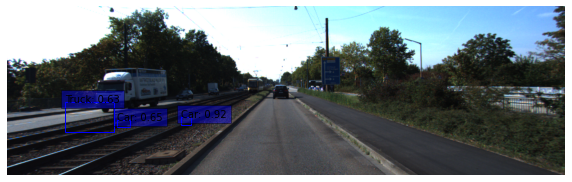

Go


In [125]:
from PIL import Image

img_path = os.getenv('HOME')+'/aiffel/object_detection/data/go_1.png'

def self_drive_assist(img_path, size_limit=6000):
    img = Image.open(img_path).convert("RGB")  # 이미지를 RGB로 변환
    img_width, img_height = img.size
    
    # PIL 이미지를 Tensorflow 텐서로 변환
    image = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    
    
    # 예측 수행
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    widths = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]
    # print(class_names)
    # go_stop = "Stop" if width > size_limit or height > size_limit else "Go"
    stop = 0
    #thre_left = img_width * 0.3
    #thre_right = img_width * 0.6
    for i in range(len(class_names)):
        if detections.nmsed_scores[0][:num_detections][i] > 0.6:
            box_width = widths[i].numpy()
            box_height = heights[i].numpy()
            ratio = box_width / box_height
            if class_names[i] in ("Car", "Truck, Tram"):
                if box_width > 200 or box_height > 150:
                    if boxes[i, 2].numpy() > img_width * 0.3:
                        if boxes[i, 0].numpy() < img_width * 0.6:
                            stop += 1
                            print(f'{i}번째 차량 문제로 Stop')
            elif class_names[i] == "Pedestrian":
                if boxes[i, 2].numpy() > img_width * 0.2:
                    if boxes[i, 0].numpy() < img_width * 0.8:
                        stop += 1
                        print(f'{i}번째 행인 발견 Stop')
    
    # 시각화
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
        figsize=(10, 10)
    )
    
    if stop >= 1:
        return "Stop"
    else:
        return "Go"

print(self_drive_assist(img_path))

# 실험 환경 평가

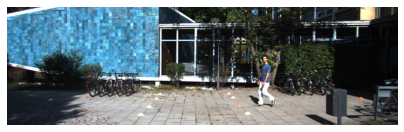

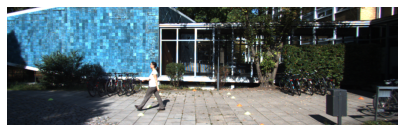

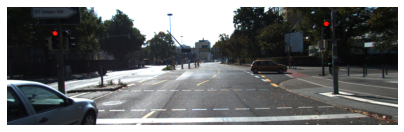

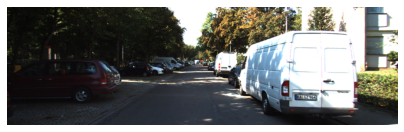

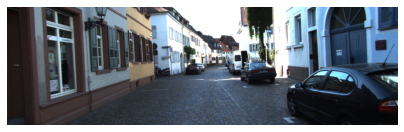

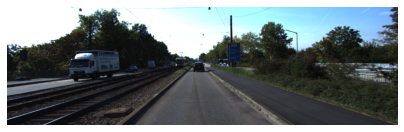

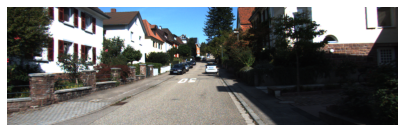

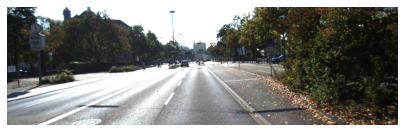

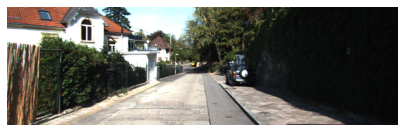

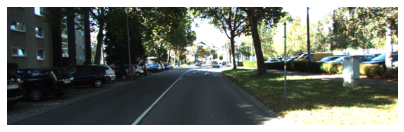

In [126]:
work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
score = 0
test_set=[
    ("stop_1.png", "Stop"),
    ("stop_2.png", "Stop"),
    ("stop_3.png", "Stop"),
    ("stop_4.png", "Stop"),
    ("stop_5.png", "Stop"),
    ("go_1.png", "Go"),
    ("go_2.png", "Go"),
    ("go_3.png", "Go"),
    ("go_4.png", "Go"),
    ("go_5.png", "Go"),
]

for image_file, answer in test_set:
    image_path = work_dir + '/' + image_file
    image = Image.open(image_path).convert("RGB")  # 이미지를 RGB로 변환
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=(7,7))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

실습에 사용되는 이미지들을 보면 사실 Go에 해당하는 사진은 문제가 없어 보이지만
3,4,5 이미지로 올바른 평가가 되는지 의문이 보임.

3 - 이는 신호등 색이 빨강, 파랑, 주황 등의 학습 데이터가 필요로 보이는데 따로 이 부분을 학습에서 반영하지 않았음

4 - 실제 운전자의 입장에선 여기서 멈추는게 더 위험한 상황으로 보임, 속도를 늦춰서 조심히 간다까진 이해

5 - 여기도 4번과 같은 사례로 꼭 멈춰야 하나 라는 생각이 듬

결론 = 좀더 많은 테스트 데이터를 확보하여 실험을 해야 이런 문제점들을 해결 가능할 것으로 보임

# 실험 진행

0번째 행인 발견 Stop


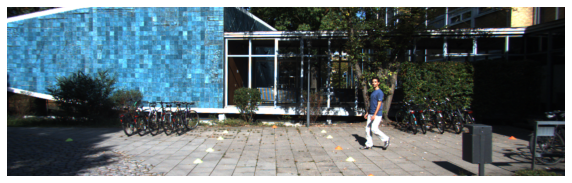

Predict: Stop, Answer: Stop


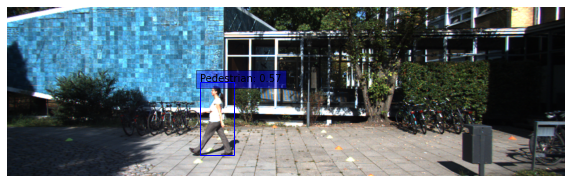

Predict: Go, Answer: Stop


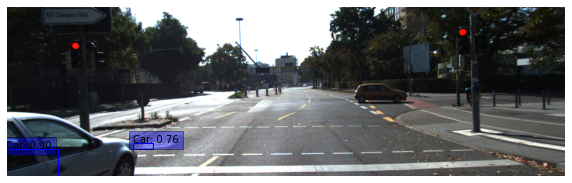

Predict: Go, Answer: Stop


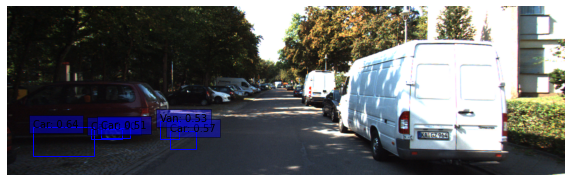

Predict: Go, Answer: Stop


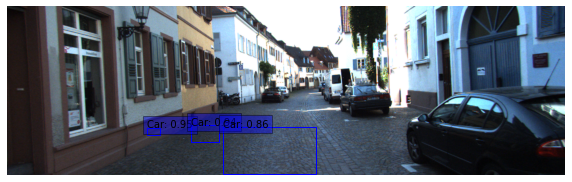

Predict: Go, Answer: Stop


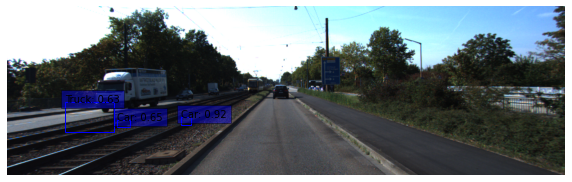

Predict: Go, Answer: Go


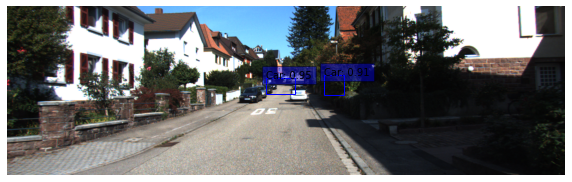

Predict: Go, Answer: Go


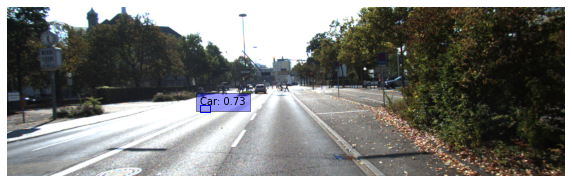

Predict: Go, Answer: Go


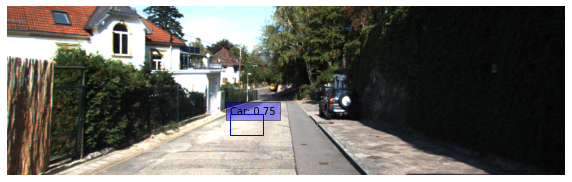

Predict: Go, Answer: Go


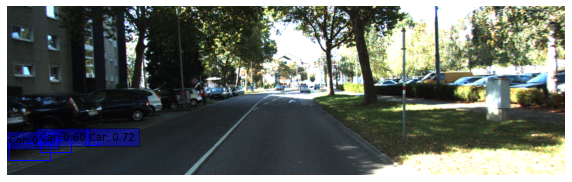

Predict: Go, Answer: Go


In [127]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f'Predict: {pred}, Answer: {answer}')
        if pred == answer:
            score += 10

test_system(self_drive_assist)

# 추가 실험

In [ ]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/git/Data/Road'
    files = os.listdir(work_dir)
    
    score = 0
    for file in files:
        pred = func(file)
        
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f'Predict: {pred}, Answer: {answer}')
        if pred == answer:
            score += 10

test_system(self_drive_assist)

# 회고